# Customer Purchase Behavior Analysis - A Real Case Study

### Probabilistic Modeling + Statistics on the Online Retail Dataset
This notebook explores customer purchase patterns using:
- Descriptive statistics: mean, median, mode, variance, std
- Distributions: Gaussian (normal) & Binomial
- Classifier: Naive Bayes to predict “high value” customers
- Visuals: histograms, KDEs, QQ plots, confusion matrix


## 1) Setup
Install all related requirments

In [2]:
%%capture
!pip install pandas ucimlrepo numpy matplotlib seaborn scikit-learn scipy openpyxl --quiet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from pathlib import Path
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


sns.set(style="whitegrid") # Specifies a visual style for the plots. It sets the background to white with a gray grid
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) # When you use the same seed, the sequence of "random" numbers generated will be identical every time


## 2) Load data

In [20]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
online_retail = fetch_ucirepo(id=352) 
  
# Fetch Online Retail dataset
df = online_retail.data.original
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 3) Inspect the data

In [21]:
print("Shape:", df.shape)
print("\nColumns and data types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isna().sum())


Shape: (541909, 8)

Columns and data types:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


We see transaction-level data — each row is a purchase event, with **invoice number, stock code, description, quantity, price, customer ID, and country**.
Some rows are missing values (common in retail data).


## 4) Basic cleaning & feature engineering
Each data needs especific cleaning and filtering so it is better to know about data and what we have in the dataset.

In [22]:
# Drop rows without CustomerID (we need them to track customers)
df = df.dropna(subset=["CustomerID"])


# Keep only positive quantities and prices
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]


# Create total price per row
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]


df.head(3)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00


In [17]:
# Drop bad rows
df = df.dropna(subset=["CustomerID"])
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]


# Parse datetime & basic features
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M").dt.to_timestamp()
df["Country"] = df["Country"].astype("category")


df.shape, df.isna().sum().sum()


((397884, 9), 397884)

## 5) Descriptive statistics
Compute mean, median, mode, variance, std for purchase metrics.


In [23]:
summary = df[["Quantity", "UnitPrice", "TotalPrice"]].agg(
    ["mean", "median", lambda x: x.mode().iloc[0], "var", "std"]
).T
summary.columns = ["Mean", "Median", "Mode", "Variance", "Std. Dev."]
summary


,Mean,Median,Mode,Variance,Std. Dev.
Quantity,12.988238,6.00,1.00,32159.885511,179.331775
UnitPrice,3.116488,1.95,1.25,488.316152,22.097877
TotalPrice,22.397000,11.80,15.00,95524.908641,309.071041


### Interpretation 
1. Mean vs. Median
- Quantity: The mean (≈ 12.99) is much higher than the median (6.0), suggesting right-skewed data (a few large orders inflate the average).
- UnitPrice: Mean ≈ 3.12, median ≈ 1.95 — indicates a similar skew: most products are cheaper, but some high-priced items pull the average up.
- TotalPrice: Mean (≈ 22.4) is also larger than median (11.8), meaning large transactions occur but are less frequent.
2. Mode
- Quantity mode = 1 → most common purchase is a single unit.
- UnitPrice mode = 1.25 → the most frequent price point in the catalog.
- TotalPrice mode = 15.0 → likely corresponds to a typical low-volume order at that price.
3. Variance & Standard Deviation
- Large variances (especially for Quantity and TotalPrice) show high spread — transactions vary greatly in size and value.
- UnitPrice has smaller std (~22), but still large relative to its mean, suggesting a few very expensive products exist.
4. Business Insight
- Most orders are small quantities, low price per unit.
- The dataset contains rare but very large orders which affect averages.
- Pricing strategy may be highly segmented — some low-cost, high-frequency items and a few premium, high-price products.


## 6) Visualizations of distributions

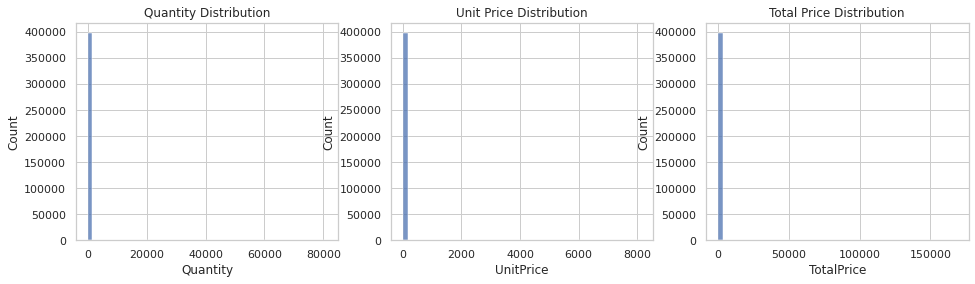

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
sns.histplot(df["Quantity"], bins=50, ax=axes[0]); axes[0].set_title("Quantity Distribution")
sns.histplot(df["UnitPrice"], bins=50, ax=axes[1]); axes[1].set_title("Unit Price Distribution")
sns.histplot(df["TotalPrice"], bins=50, ax=axes[2]); axes[2].set_title("Total Price Distribution")
plt.show()


* Most items are sold in small quantities.
* Most products have low unit price, but some luxury items are very expensive.
* Total price shows a few very large transactions (long tail).


## 7) Gaussian (Normal) distribution check

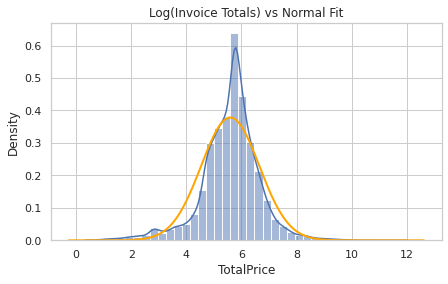

In [26]:
invoice_totals = df.groupby("InvoiceNo")["TotalPrice"].sum()
log_totals = np.log1p(invoice_totals)


mu, sigma = stats.norm.fit(log_totals)


fig, ax = plt.subplots(figsize=(7,4))
sns.histplot(log_totals, kde=True, stat="density", bins=40, ax=ax)
xmin, xmax = ax.get_xlim()
xs = np.linspace(xmin, xmax, 200)
ax.plot(xs, stats.norm.pdf(xs, mu, sigma), color="orange", lw=2)
ax.set_title("Log(Invoice Totals) vs Normal Fit")
plt.show()
